# Quidditch Object Detection

references: 
* [How to play Quidditch using the TensorFlow Object Detection API](https://medium.freecodecamp.org/how-to-play-quidditch-using-the-tensorflow-object-detection-api-b0742b99065d)
* [Raccoon Detector Dataset](https://github.com/datitran/raccoon_dataset)


## Import

In [1]:
import numpy as np
import pandas as pd
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

At this point assuming:
- gathered all train and test images and located them in proper dir
- labeled all the images

## Convert annotated (xml) files to csv

In [2]:
# convet xml image files to csv
! xml_to_csv.py

Successfully converted xml to labels.csv.


In [4]:
labels = pd.read_csv('data/labels.csv')

print(labels.shape)
labels.head()

(398, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,0.jpg,1280,586,bludger,855,300,895,345
1,0.jpg,1280,586,quaffle,647,365,757,458
2,1.jpg,1280,586,quaffle,650,399,697,450
3,10.jpg,1280,586,quaffle,851,329,896,406
4,100.jpg,1280,586,quaffle,482,185,605,314


## Generate TFRecord

In [5]:
! python create_tf_record.py --csv_input=data/labels.csv --output_path=data/

Successfully created the TFRecords: C:\Users\Gabe\Desktop\work\201809-Quidditch-Detection\data/train.record
Successfully created the TFRecords: C:\Users\Gabe\Desktop\work\201809-Quidditch-Detection\data/test.record


## Download the model and configuration

I've decided to use faster rcnn inception model for this particular project.

More models available at [detection zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)

In [6]:
# What model to download.
MODEL_NAME = 'faster_rcnn_inception_v2_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

### unmark below to download the model
# opener = urllib.request.URLopener()
# opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
tar_file.extractall()

### get configuration
* Refer to [sample configurations](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs)
* Edit Num_of_Classes and paths and other hyperparams as I desire

## Train the model

In [ ]:
python ../tensorflow-models/research/object_detection/model_main.py \
    --model_dir=faster_rcnn_inception_model/ \
    --pipeline_config_path=faster_rcnn_inception_v2_coco.config \
    --alsologtostderr  
# python C:/Users/Gabe/Desktop/work/tensorflow-models/research/object_detection/model_main.py --model_dir=C:/Users/Gabe/Desktop/work/201809-Quidditch-Detection/faster_rcnn_inception_model/ --pipeline_config_path=C:/Users/Gabe/Desktop/work/201809-Quidditch-Detection/faster_rcnn_inception_v2_coco.config --alsologtostderr  

## Save a Frozen Model

In [ ]:
! python ../tensorflow-models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=faster_rcnn_inception_model/pipeline.config \
    --trained_checkpoint_prefix=faster_rcnn_inception_model/model.ckpt-6446 \
    --output_directory=faster_rcnn_inception_model/output/

## Try Detection

In [7]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

### Load a (frozen) Tensorflow model into memory

In [ ]:
PATH_TO_FROZEN_GRAPH = 'ssd_model/frozen_inference_graph.pb'

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

### Load labelmap

In [8]:
from utils import label_map_util
from utils import visualization_utils as vis_util

ERROR! Session/line number was not unique in database. History logging moved to new session 503


C:\Users\Gabe\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [9]:
label_map = label_map_util.load_labelmap('data/label_map.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=3, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Results

In [2]:
from IPython.display import display, Image, HTML

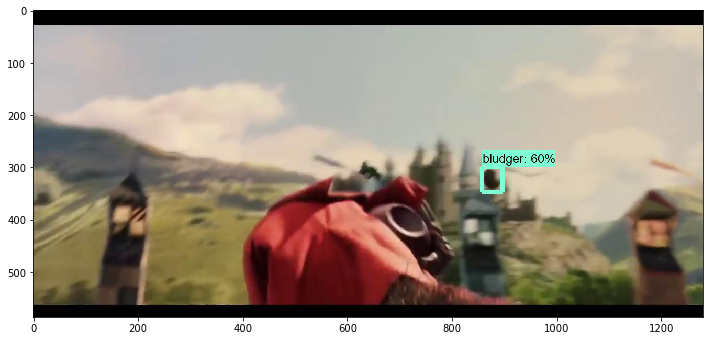

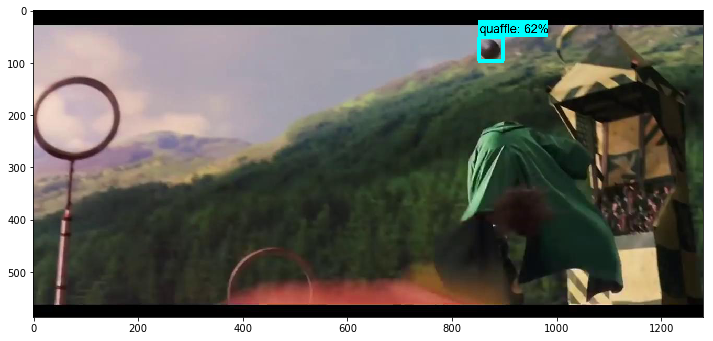

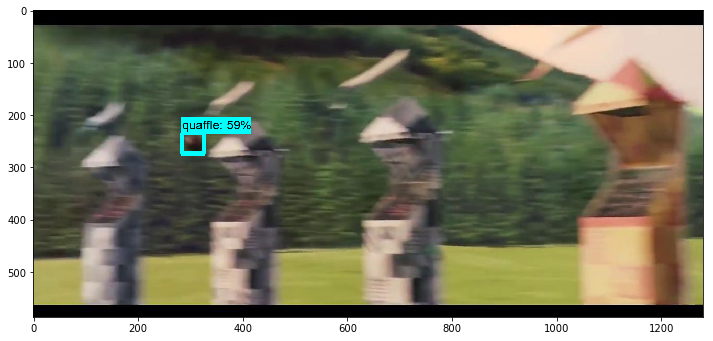

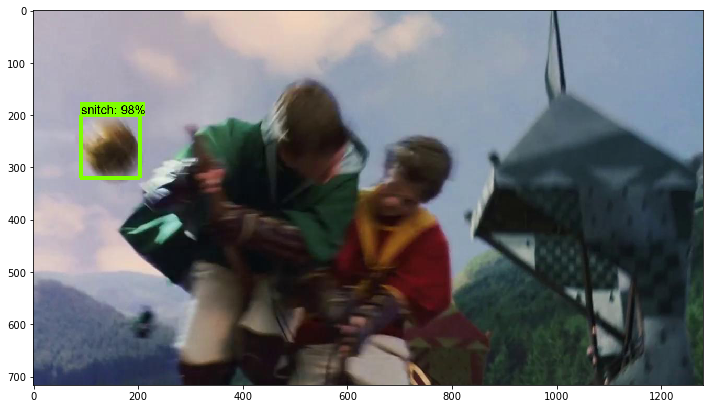

In [48]:
RESULT_PATH = 'result/'
img1= Image(filename = RESULT_PATH + "1.png", width=600, height=400)
img2= Image(filename = RESULT_PATH + "2.png", width=600, height=400)
img3= Image(filename = RESULT_PATH + "3.png", width=600, height=400)
img4= Image(filename = RESULT_PATH + "4.png", width=600, height=400)

display(img1, img2, img3, img4)

In [7]:
HTML("""<video width="640" height="480" controls>
          <source src="result/annotated.mp4" type="video/mp4">
        </video>""")